# IWAE vs VAE: Analysis Notebook

This notebook aggregates the analysis results for the comparison between VAE (K=1) and IWAE (K=5).

## 1. Setup & Imports

In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt

# Add src to path
sys.path.append(os.path.abspath('.'))

from src.models.vae import VAE
from src.models.iwae import IWAE
from src.data.mnist_loader import get_dataloaders
from src.analysis.visualize import plot_reconstruction, plot_samples
from src.analysis.active_units import calc_active_units, plot_kl_stats
from src.analysis.evaluate_likelihood import evaluate_model
from src.analysis.gradient_variance import compute_gradient_variance

# Config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Paths
vae_path = 'checkpoints/vae_k1_epochs50_seed42.pt'
iwae_path = 'checkpoints/iwae_k5_epochs50_seed42.pt'

output_dir = './notebook_results'
os.makedirs(output_dir, exist_ok=True)

Using device: cuda


## 2. Load Models and Data

In [2]:
input_size = 784
hidden_size = 200
latent_size = 50
output_size = 784

# Load VAE
vae = VAE(input_size, hidden_size, latent_size, output_size)
vae.load_state_dict(torch.load(vae_path, map_location=device))
vae.to(device)
print("VAE Loaded.")

# Load IWAE
iwae = IWAE(5, input_size, hidden_size, latent_size, output_size)
iwae.load_state_dict(torch.load(iwae_path, map_location=device))
iwae.to(device)
print("IWAE Loaded.")

# Data
train_loader, val_loader, test_loader = get_dataloaders(batch_size=32)

VAE Loaded.
IWAE Loaded.
Data Loaded: Train 50000, Val 10000, Test 10000


## 3. Qualitative Comparison: Reconstructions & Samples

Reconstructions saved to ./notebook_results/vae_recon.png
Samples saved to ./notebook_results/vae_samples.png
Reconstructions saved to ./notebook_results/iwae_recon.png
Samples saved to ./notebook_results/iwae_samples.png


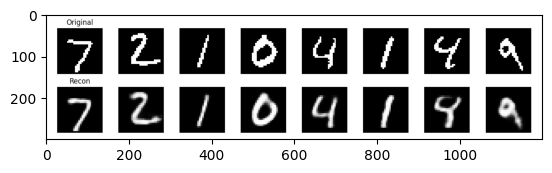

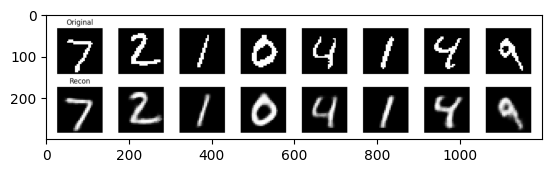

In [8]:
# VAE Visuals
plot_reconstruction(vae, test_loader, device, f"{output_dir}/vae_recon.png")
plot_samples(vae, device, f"{output_dir}/vae_samples.png")

# IWAE Visuals
plot_reconstruction(iwae, test_loader, device, f"{output_dir}/iwae_recon.png")
plot_samples(iwae, device, f"{output_dir}/iwae_samples.png")

# Display (if running in interactive notebook)
plt.imshow(plt.imread(f"{output_dir}/vae_recon.png"))
plt.show()

plt.imshow(plt.imread(f"{output_dir}/iwae_recon.png"))
plt.show()

## 4. Quantitative Comparison: Log-Likelihood (IWAE bound, K=200)

In [9]:
k_eval = 5000
print(f"Estimating LL with K={k_eval}...")

# We strictly use IWAE logic for evaluation (even for VAE weights)
evaluator = IWAE(k_eval, input_size, hidden_size, latent_size, output_size).to(device)

# Evaluate VAE
evaluator.load_state_dict(vae.state_dict())
vae_ll = evaluate_model(evaluator, test_loader, device, k_eval)
print(f"VAE LL: {vae_ll:.4f}")

# Evaluate IWAE
evaluator.load_state_dict(iwae.state_dict())
iwae_ll = evaluate_model(evaluator, test_loader, device, k_eval)
print(f"IWAE LL: {iwae_ll:.4f}")

print(f"Improvement: {iwae_ll - vae_ll:.4f} nats")

Estimating LL with K=5000...


VAE LL: -81.0562


IWAE LL: -78.3550
Improvement: 2.7011 nats


## 5. Posterior Collapse Analysis: Effective KL

In [10]:
print("Analyzing Active Units...")

n_vae, vae_kls = calc_active_units(vae, test_loader, device)
n_iwae, iwae_kls = calc_active_units(iwae, test_loader, device)

print(f"VAE Active Units: {n_vae}")
print(f"IWAE Active Units: {n_iwae}")

plot_kl_stats(vae_kls, "VAE", f"{output_dir}/vae_kl.png")
plot_kl_stats(iwae_kls, "IWAE", f"{output_dir}/iwae_kl.png")

Analyzing Active Units...


VAE Active Units: 15
IWAE Active Units: 22
Plot saved to ./notebook_results/vae_kl.png
Plot saved to ./notebook_results/iwae_kl.png


## 6. Gradient Variance Analysis (SNR)

In [11]:
# Get a batch
data, _ = next(iter(train_loader))
data = data.to(device)

print("Comparing Gradient SNR...")

var_vae, snr_vae = compute_gradient_variance(vae, data, n_runs=50)
print(f"VAE SNR: {snr_vae:.4f}")

var_iwae, snr_iwae = compute_gradient_variance(iwae, data, n_runs=50)
print(f"IWAE SNR: {snr_iwae:.4f}")

Comparing Gradient SNR...
VAE SNR: 0.4174
IWAE SNR: 0.2381
